In [2]:
import requests
import pandas as pd
import time


In [3]:
def fetch_no_fluff_data_v3(
    pages=3,
    limit=50,
    keyword="python",
    salary_currency="PLN",
    salary_period="month",   # spotyka się: "month" / "hour" (zależnie od endpointu)
    region="pl",
    sleep_s=1.0
):
    all_jobs = []
    base_url = "https://nofluffjobs.com/api/search/posting"

    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
        "Content-Type": "application/json",
        "Referer": "https://nofluffjobs.com/",
        "Accept": "application/json"
    }

    print("Start pobierania…")

    with requests.Session() as s:
        s.headers.update(headers)

        for page in range(1, pages + 1):
            offset = (page - 1) * limit

            # >>> KLUCZ: wymagane parametry idą w query string <<<
            params = {
                "salaryCurrency": salary_currency,
                "salaryPeriod": salary_period,
                "region": region,
                "limit": limit,
                "offset": offset,
            }

            # Filtry/criteria idą w body (nazywa się to często CriteriaSearch)
            payload = {
                "page": page,
                "criteriaSearch": {
                    "requirement": [keyword]
                }
            }

            r = s.post(base_url, params=params, json=payload, timeout=30)

            if r.status_code != 200:
                # pokaż sensowny kawałek odpowiedzi, ale też spróbuj json
                try:
                    err = r.json()
                except Exception:
                    err = r.text[:300]
                print(f"Strona {page}: BŁĄD {r.status_code} -> {err}")
                continue

            data = r.json()
            postings = data.get("postings", []) or []
            print(f"Strona {page}: OK, ogłoszeń: {len(postings)}")

            for job in postings:
                salary = job.get("salary") or {}
                low = salary.get("from")
                high = salary.get("to")

                # Uwaga: część ofert nie ma widełek w tym callu/okresie/walucie
                salary_avg = None
                if isinstance(low, (int, float)) and isinstance(high, (int, float)):
                    salary_avg = (low + high) / 2

                places = (job.get("location") or {}).get("places") or []
                city = places[0].get("city") if places and isinstance(places[0], dict) else None

                all_jobs.append({
                    "title": job.get("title"),
                    "city": city or "Remote/Unknown",
                    "level": (job.get("seniority") or ["n/a"])[0],
                    "category": job.get("category"),
                    "salary_from": low,
                    "salary_to": high,
                    "salary_avg": salary_avg,
                    "currency": salary.get("currency") or salary_currency,
                })

            time.sleep(sleep_s)

    return pd.DataFrame(all_jobs)

df = fetch_no_fluff_data_v3(pages=3, keyword="python", salary_currency="PLN", salary_period="month", region="pl")
df.head()

Start pobierania…
Strona 1: OK, ogłoszeń: 489
Strona 2: OK, ogłoszeń: 489
Strona 3: OK, ogłoszeń: 489


,title,city,level,category,salary_from,salary_to,salary_avg,currency
0,Lead Python Engineer,Białystok,Expert,backend,16800.0,27720.0,22260.0,PLN
1,Lead Python Engineer,Warsaw,Expert,backend,16800.0,27720.0,22260.0,PLN
2,Lead Python Engineer,Gdańsk,Expert,backend,16800.0,27720.0,22260.0,PLN
3,Lead Python Engineer,Łódź,Expert,backend,16800.0,27720.0,22260.0,PLN
4,Lead Python Engineer,Wrocław,Expert,backend,16800.0,27720.0,22260.0,PLN


In [4]:
print("Shape (wiersze, kolumny):", df.shape)

Shape (wiersze, kolumny): (1467, 8)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1467 entries, 0 to 1466
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        1467 non-null   object 
 1   city         1467 non-null   object 
 2   level        1467 non-null   object 
 3   category     1467 non-null   object 
 4   salary_from  1467 non-null   float64
 5   salary_to    1467 non-null   float64
 6   salary_avg   1467 non-null   float64
 7   currency     1467 non-null   object 
dtypes: float64(3), object(5)
memory usage: 91.8+ KB


In [6]:
(df.isna().mean() * 100).sort_values(ascending=False)

title          0.0
city           0.0
level          0.0
category       0.0
salary_from    0.0
salary_to      0.0
salary_avg     0.0
currency       0.0
dtype: float64

In [7]:
df["salary_avg"].notna().mean() * 100

100.0

In [8]:
dups_top = (
    df.groupby(["title", "salary_from", "salary_to", "city", "level"])
      .size()
      .sort_values(ascending=False)
      .head(20)
)

dups_top


title                                                       salary_from  salary_to  city            level 
Fullstack Software Engineer (Python + Vue.js)               12600.0      19320.0    Remote/Unknown  Mid       54
Senior Python (Web) Developer                               20160.0      23520.0    Remote/Unknown  Senior    48
Senior Python Developer                                     23520.0      27720.0    Remote/Unknown  Senior    48
                                                            25293.0      33724.0    Remote/Unknown  Senior    48
Senior Python Developer - Remote                            23000.0      26000.0    Remote/Unknown  Senior    48
Junior Python Developer (Django DRF)                        4500.0       6500.0     Remote/Unknown  Junior    48
Mid Python Developer                                        15000.0      20000.0    Remote/Unknown  Mid       48
Python (Django) + React Developer (Strong Middle / Senior)  10538.0      21077.0    Remote/Unknown  Se

In [9]:
key_cols = ["title", "salary_from", "salary_to", "city", "level"]

df_clean = (
    df
    .drop_duplicates(subset=key_cols)
    .reset_index(drop=True)
)

print("Przed:", len(df))
print("Po:", len(df_clean))


Przed: 1467
Po: 142


In [10]:
df_clean.head()

,title,city,level,category,salary_from,salary_to,salary_avg,currency
0,Lead Python Engineer,Białystok,Expert,backend,16800.0,27720.0,22260.0,PLN
1,Lead Python Engineer,Warsaw,Expert,backend,16800.0,27720.0,22260.0,PLN
2,Lead Python Engineer,Gdańsk,Expert,backend,16800.0,27720.0,22260.0,PLN
3,Lead Python Engineer,Łódź,Expert,backend,16800.0,27720.0,22260.0,PLN
4,Lead Python Engineer,Wrocław,Expert,backend,16800.0,27720.0,22260.0,PLN


In [11]:
len(df_clean)


142

In [19]:
import numpy as np

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
# uporządkowanie level (to jest kluczowe dla wykresu liniowego)
level_order = ["junior", "mid", "senior"]

df_plot = (
    df_clean
    .assign(level=df_clean["level"].str.lower())
    .loc[df_clean["level"].str.lower().isin(level_order)]
    .groupby(["title", "level"], as_index=False)
    .agg(
        salary_median=("salary_avg", "median"),
        n=("salary_avg", "count")
    )
)

df_plot["level"] = pd.Categorical(
    df_plot["level"],
    categories=level_order,
    ordered=True
)

df_plot.head()


,title,level,salary_median,n
0,Engineering Lead / Manager,senior,28000.0,1
1,Expert Fullstack Django & Angular Developer,mid,22596.0,1
2,Frontend Software Engineer,mid,12525.5,1
3,"Full Stack Software Engineer (Python, React, AWS)",mid,17945.0,1
4,Fullstack Software Engineer (Python + Vue.js),mid,15960.0,9


In [14]:
top_titles = (
    df_plot.groupby("title")["n"]
    .sum()
    .sort_values(ascending=False)
    .head(8)
    .index
)

df_plot_top = df_plot[df_plot["title"].isin(top_titles)]


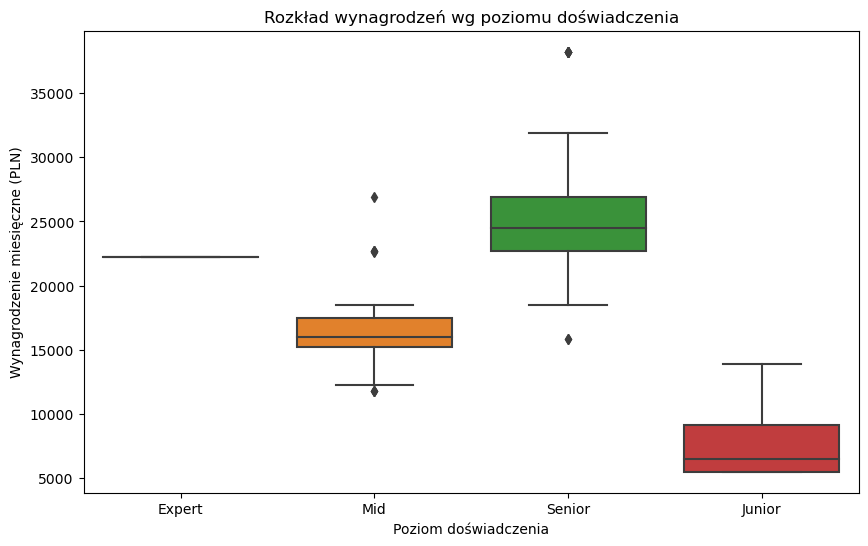

In [15]:
plt.figure(figsize=(10, 6))

sns.boxplot(
    data=df_clean,
    x="level",
    y="salary_avg"
)

plt.title("Rozkład wynagrodzeń wg poziomu doświadczenia")
plt.xlabel("Poziom doświadczenia")
plt.ylabel("Wynagrodzenie miesięczne (PLN)")
plt.show()


sns.violinplot(data=df_clean, x="level", y="salary_avg", inner="quartile")


**Wniosek:**  
Mediana wynagrodzeń rośnie wraz z poziomem doświadczenia, przy czym grupa Senior
charakteryzuje się znacznie większym rozrzutem widełek płacowych niż poziom Mid.
